# Bootstrap

Не всегда тот показатель, который нас интересует во время анализа, можно проверить готовым тестом. Для подобных непонятных ситуаций аналитиками часто используется метод бутстрапа (bootstrap), позволяющий оценить доверительный интервал для любого интересующего нас показателя.

Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках эксперимента. В полученных подвыборках считаются статистики (среднее, медиана и т.п.). Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
from scipy.stats import bootstrap, mannwhitneyu, ttest_ind, norm
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [4]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [5]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

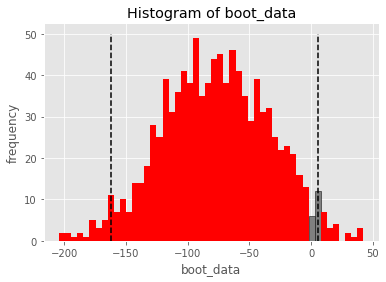

In [6]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [7]:
booted_data["p_value"] # альфа

0.07704553867678232

In [8]:
booted_data["quants"] # ДИ

,0
0.025,-161.943418
0.975,5.328283


In [9]:
data_ab = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/hw_bootstrap.csv', sep=';', decimal=',')

In [10]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [11]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [12]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


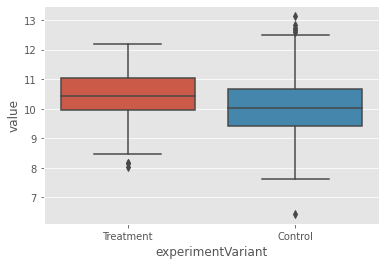

In [13]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

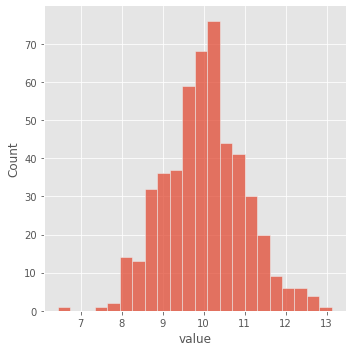

In [14]:
sns.displot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

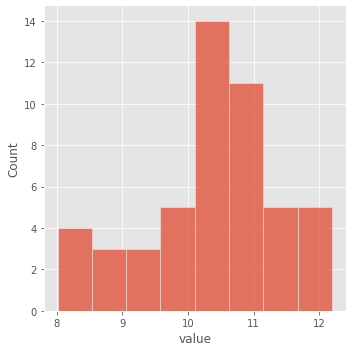

In [15]:
sns.displot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [16]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=15492.0, pvalue=0.005236419587596797)

In [17]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.3318589655730135, pvalue=0.02006953912735476)

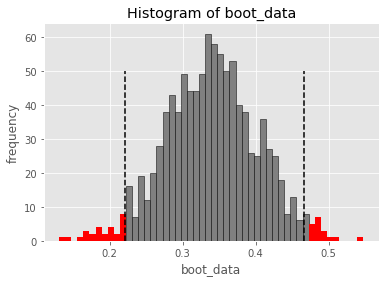

{'boot_data': [0.18776922743289304,
  0.2743838675211076,
  0.3909727989808199,
  0.3904828832226608,
  0.3148571793586496,
  0.3069757794930819,
  0.33629241069251303,
  0.2495038678188318,
  0.28549502999860166,
  0.3264786929742884,
  0.3346640724381806,
  0.20350194545007172,
  0.36711279749907466,
  0.375955783001078,
  0.47637116871403024,
  0.21050188748730733,
  0.3996596272650998,
  0.21706371747252268,
  0.3205050287524081,
  0.2999072255449676,
  0.3451589979116176,
  0.3711652313496435,
  0.487194465404953,
  0.3866340784031173,
  0.4291399125597986,
  0.3559036189255172,
  0.3610108676411263,
  0.2950572590683745,
  0.3110935006794872,
  0.35442805077715595,
  0.34979957789697175,
  0.3667140741186572,
  0.2904463981998922,
  0.42686031890116566,
  0.3416520081021791,
  0.3576769284411188,
  0.3436850660528669,
  0.4083918267424844,
  0.2811616991153623,
  0.37474344837619555,
  0.3999903035240065,
  0.354161930324762,
  0.36266674432372653,
  0.31089380881186346,
  0.2835

In [18]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

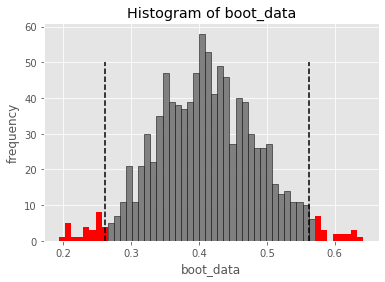

{'boot_data': [0.4759590488007053,
  0.44919718704470046,
  0.3980850896149004,
  0.3608391225914547,
  0.42894577490037555,
  0.5177598200697897,
  0.46535184538277985,
  0.5216242095347843,
  0.42673026232804023,
  0.6216133341671108,
  0.6044745340126498,
  0.38857443843664985,
  0.4355556135150298,
  0.29364374617109945,
  0.41421348130971936,
  0.4114498002537008,
  0.31347990476915477,
  0.48392564486073475,
  0.44698244282565014,
  0.41460889208093477,
  0.4515132516660145,
  0.3438899140025464,
  0.42707226369779505,
  0.383433889327101,
  0.30457351226240004,
  0.40081608397083457,
  0.454579907957104,
  0.4031289695497815,
  0.4441734506115651,
  0.4405413255045145,
  0.3747500922973863,
  0.29152425843473484,
  0.3906667841172,
  0.31474915236984913,
  0.43414578468348,
  0.4729840338595759,
  0.5017382678905644,
  0.4432384102167397,
  0.3638246107155503,
  0.29613859624205485,
  0.2521697111478147,
  0.4174575927235349,
  0.40600335444540026,
  0.4363476563528996,
  0.4246

In [19]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)


In [20]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/bootstrap_data.csv')

In [21]:
df.head()

,value,group
0,100.719713,experimental
1,106.771525,experimental
2,106.974612,experimental
3,109.249662,experimental
4,116.230142,experimental


In [22]:
df.groupby('group').agg({'value' : 'count'})

,value
group,
control,760
experimental,494


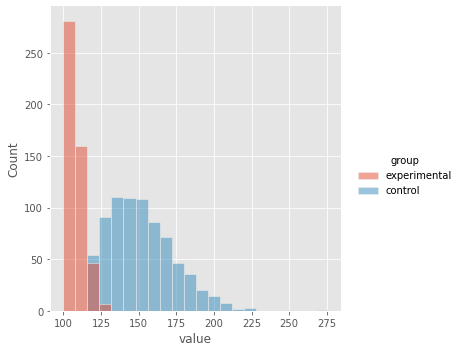

In [23]:
sns.displot(data=df, x="value", hue="group")

In [24]:
df.groupby('group').agg({'value': 'median'})

,value
group,
control,148.832127
experimental,106.982597


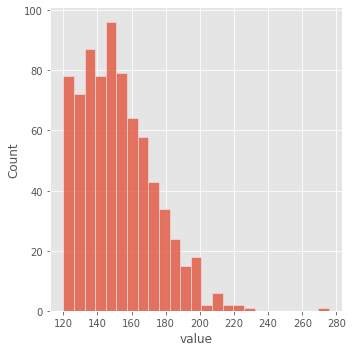

In [25]:
sns.displot(data=df[df.group == 'control'], x="value")

In [26]:
control_df = df[df.group == 'control']

In [27]:
control_df.value.median()

148.83212650911054

In [28]:
medians = []

In [29]:
n = 10000

In [30]:
#  симуляция с повторениями значений
for i in range(n):
    sample_data = control_df.sample(frac=1, replace=True)
    sample_median = sample_data.value.median()
    medians.append(sample_median)

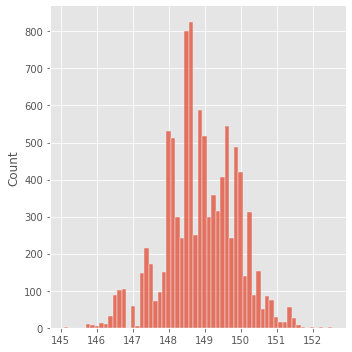

In [31]:
sns.displot(medians)

In [32]:
# доверительный 95% интервал для медианы
pd.Series(medians).quantile(0.975)

150.79195404716063

In [33]:
pd.Series(medians).quantile(0.025)

146.6820347417457

In [34]:
# аналогично вычисляется ДИ для экспериментальной группы и если они не пересекаются, получили стат значимые различия между медианами

In [35]:
# то же самое, только одной функцией
bootstrap((control_df.value, ), np.median)
# также можно сравнивать средние с np.mean

BootstrapResult(confidence_interval=ConfidenceInterval(low=146.6409232925935, high=150.77637997981842), standard_error=0.9916131379880585)

In [36]:
exp_df = df[df.group == 'experimental']
median_diff = []

for i in range(10000):
    sample_data_control = control_df.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.value.median()
    
    
    sample_data_exp = exp_df.sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.value.median()
    
    sample_median_diff = sample_median_control - sample_median_exp
    median_diff.append(sample_median_diff) 

In [37]:
# ДИ для разницы медиан
pd.Series(median_diff).quantile(0.975)

43.90580278696329

In [38]:
pd.Series(median_diff).quantile(0.025)

39.71834250600381

ДИ далек от 0, т.о. можем говорить о том, что медианы стат значимо различаются